In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
import matplotlib.pyplot as plt
from glob import glob
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

In [2]:
from glob import glob
import pickle
import numpy as np
from sklearn.preprocessing import MinMaxScaler

ROOT_PATH = "./argo2/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]
sc = MinMaxScaler()

def get_city_trajectories(city="palo-alto", split="train", normalized=False):
    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.8)]
        
        full_data = np.concatenate((inputs, outputs), axis=1)
        full_data = full_data.reshape((-1,110))
        full_data = sc.fit_transform(full_data)
        full_data = full_data.reshape((-1,110,2))
        full_data = np.split(full_data, [50,110], axis=1)
        
        inputs = Variable(torch.tensor(full_data[0], dtype=torch.float32))
        outputs = Variable(torch.tensor(full_data[1], dtype=torch.float32))
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
        
        full_data = np.concatenate((inputs, outputs), axis=1)
        full_data = full_data.reshape((-1,110))
        full_data = sc.fit_transform(full_data)
        full_data = full_data.reshape((-1,110,2))
        full_data = np.split(full_data, [50,110], axis=1)
        
        inputs = Variable(torch.tensor(full_data[0], dtype=torch.float32))
        outputs = Variable(torch.tensor(full_data[1], dtype=torch.float32))
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)
        
        full_data = np.concatenate((inputs, outputs), axis=1)
        full_data = full_data.reshape((-1,110))
        full_data = sc.fit_transform(full_data)
        full_data = full_data.reshape((-1,110,2))
        full_data = np.split(full_data, [50,110], axis=1)
        
        inputs = Variable(torch.tensor(full_data[0], dtype=torch.float32))
        outputs = Variable(torch.tensor(full_data[1], dtype=torch.float32))

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

# intialize a dataset
city = 'palo-alto' 
split = 'train'
train_dataset  = ArgoverseDataset(city = city, split = split)

In [3]:
train_dataset = ArgoverseDataset(city = city, split= 'train')
val_dataset = ArgoverseDataset(city = city, split = 'val')

In [4]:
batch_sz = 50  # batch size 
val_loader = DataLoader(val_dataset,batch_size=batch_sz)
train_loader = DataLoader(train_dataset,batch_size=batch_sz)

In [5]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):  
        
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

In [6]:
seq_length = 50
num_epochs = 10
learning_rate = 0.01

input_size = 2
hidden_size = 50
num_layers = 1

num_classes = 2

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)


for epoch in range(num_epochs):
    total_loss = 0
    
    for i_batch, sample_batch in enumerate(val_loader):
        inp, out = sample_batch
        for i in range(60):
            temp_out = out[:,i,:]
            outputs = lstm(inp)
            optimizer.zero_grad()
            loss = criterion(outputs, temp_out)
            loss.backward()
            optimizer.step()
            total_loss+=loss.item()
            temp_out = temp_out.reshape((-1,1,2))
            inp = torch.cat((inp[:,1:],temp_out), axis=1)
        
    print('epoch {} loss: {}'.format(epoch, total_loss / len(train_dataset)))

epoch 0 loss: 0.0002077645033225873
epoch 1 loss: 6.22388784414188e-06
epoch 2 loss: 4.508034372833434e-06
epoch 3 loss: 4.089621112160233e-06
epoch 4 loss: 3.3664878518743662e-06
epoch 5 loss: 4.057598363666476e-06
epoch 6 loss: 1.8017910194667405e-06
epoch 7 loss: 2.653271330012561e-06
epoch 8 loss: 7.3747969280840595e-06
epoch 9 loss: 1.106646673244142e-05


In [22]:
torch.save(lstm.state_dict(), "lstm.pth")

In [15]:
def create_random_plot():
    for i_batch, sample_batch in enumerate(val_loader):
        rand = np.random.randint(batch_sz, size=1)
        inp, out = sample_batch
        true_full = np.concatenate((inp,out),axis=1)
        preds = []
        for i in range(50):
            preds.append(np.array(inp[rand,i,:]))
        for i in range(60):
            pred = lstm(torch.tensor(true_full[:,i:i+50,:],dtype=torch.float32)).detach().numpy()
            preds.append(np.array(pred[rand,:]))
        preds = np.array(preds).reshape(-1,110)
        preds = sc.inverse_transform(preds)
        preds = preds.reshape(110,2)
        pred_x = preds[:,0]
        pred_y = preds[:,1]
        true_full = true_full.reshape(-1,110)
        true_full = sc.inverse_transform(true_full)
        true_full = true_full.reshape(-1,110,2)
        true_x = true_full[rand,:,0]
        true_y = true_full[rand,:,1]
        plt.scatter(true_x,true_y, color='blue', alpha=0.5)
        plt.scatter(pred_x,pred_y, color='green', alpha=0.5)
        plt.show()
        break

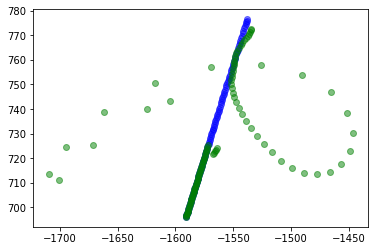

In [20]:
create_random_plot()